<a href="https://colab.research.google.com/github/deepakri201/SEG_and_SR_for_NLSTSeg/blob/main/SEG_and_SR_for_NLSTSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DICOM Segmentation and Structured Report files for the NLST collection - using NLSTSeg annotations

This notebook creates DICOM Segmentation objects for the NLST collection, based on the expert annotations from [this paper](https://www.nature.com/articles/s41597-025-05742-x)

Notes:
- Can also include lobe of lung in the DICOM SEG file
- What about the lung cancer stage?
- Use the IDC-03 codes instead of SNOMED - also in NLST.

Deepa Krishnaswamy

Brigham and Women's Hospital

September 2025

In [1]:
!pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git

  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-7c5aiu87
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-7c5aiu87
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 269.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 276.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 394.4 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=20206f4db1f44dc4ba977fcd8b3baa50f233ce0f57d3729a68ac6b6888572857
  Stored in directory

In [2]:
# output_seg_bucket = "gs://seg_nlst"
input_bucket = "gs://nlstseg" # holds the actual tables and raw data
output_bucket = "gs://nlstseg_seg_and_sr" # holds the output SEG and SR

# Parameterization

In [3]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [4]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [5]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [6]:
import os
import sys
import time

import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path

from google.cloud import bigquery
from google.cloud import storage

In [7]:
# DCMQI - to convert nifti to DICOM Segmentation object
!wget https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
!tar zxvf dcmqi-1.4.0-linux.tar.gz
!cp dcmqi-1.4.0-linux/bin/* /usr/local/bin/

--2025-09-17 15:42:23--  https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/915cb14a-48f5-4288-9a5f-bfbcc67daf43?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-17T16%3A33%3A12Z&rscd=attachment%3B+filename%3Ddcmqi-1.4.0-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-17T15%3A32%3A55Z&ske=2025-09-17T16%3A33%3A12Z&sks=b&skv=2018-11-09&sig=9%2BKTkFViC1aP2b5wVJIgyde6n7KmOX09CuJFdpDBae0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODEyNDA0MywibmJmIjoxNzU4MTIzNzQzLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install pydicom
from pydicom.sr.codedict import codes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.6 MB/s eta 0:00:00


In [10]:
import pydicom

In [11]:
import shutil

In [12]:
import copy

In [13]:
!pip install zenodo-get

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 11.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=aee96226f160d455e53d0e258afa420c5f7f540be210daeaaed22efe283fde6d
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [14]:
# !wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip dcm2niix_lnx.zip
# !cp /content/dcm2niix /usr/local/bin

!wget "https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip" \
&& unzip "dcm2niix_lnx.zip" \
&& rm "dcm2niix_lnx.zip" \
&& mv dcm2niix /usr/local/bin/dcm2niix

--2025-09-17 15:42:59--  https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/25434012/c74be71a-a73f-4945-a116-f02b58a43adf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-17T16%3A31%3A03Z&rscd=attachment%3B+filename%3Ddcm2niix_lnx.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-17T15%3A31%3A01Z&ske=2025-09-17T16%3A31%3A03Z&sks=b&skv=2018-11-09&sig=iSPbxznMo6qGEBUfwKb4Quy32DCbU1HSa2%2FkebqRMvk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODEyNDA4MCwibmJmIjoxNzU4MTIzNzgwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjd

In [15]:
import subprocess

In [16]:
# !pip install --no-cache-dir pyradiomics
# !pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git
import radiomics
from radiomics import featureextractor, generalinfo

In [17]:
import logging

In [18]:
from functools import partial

In [19]:
from tqdm import tqdm

In [20]:
from pydicom import dcmread

In [21]:
import SimpleITK as sitk

# Download

In [22]:
# Already uploaded these files from a bucket
# So, download from bucket, since Zenodo is slow

# # Has 1 tumor
# !gsutil cp "gs://nlstseg/data/100012_tumor.nii.gz" "/content/100012_tumor.nii.gz"
# SeriesInstanceUID_list = ['1.2.840.113654.2.55.135088253786049275791463451273034430925']
# seg_filename = "/content/100012_tumor.nii.gz"

# Has 3 tumors
# !gsutil cp "gs://nlstseg/data/100658_tumor.nii.gz" "/content/100658_tumor.nii.gz"
# SeriesInstanceUID_list = ['1.2.840.113654.2.55.264823538108475401141178460625066576318']
# seg_filename = "/content/100658_tumor.nii.gz"

In [23]:
# Download tables - also in BQ.

if not os.path.isdir("/content/table"):
  os.mkdir("/content/table")

nlstseg_image_filename = os.path.join(input_bucket, "table", "Image.xlsx")
nlstseg_patient_filename = os.path.join(input_bucket, "table", "Patient.xlsx")
nlstseg_label_filename = os.path.join(input_bucket, "table", "Label.xlsx")

!gsutil cp $nlstseg_image_filename "/content/table/Image.xlsx"
!gsutil cp $nlstseg_patient_filename "/content/table/Patient.xlsx"
!gsutil cp $nlstseg_label_filename "/content/table/Label.xlsx"

Copying gs://nlstseg/table/Image.xlsx...
/ [1 files][ 67.3 KiB/ 67.3 KiB]                                                
Operation completed over 1 objects/67.3 KiB.                                     
Copying gs://nlstseg/table/Patient.xlsx...
/ [1 files][ 38.5 KiB/ 38.5 KiB]                                                
Operation completed over 1 objects/38.5 KiB.                                     
Copying gs://nlstseg/table/Label.xlsx...
/ [1 files][ 70.8 KiB/ 70.8 KiB]                                                
Operation completed over 1 objects/70.8 KiB.                                     


# Files for pyradiomics

In [24]:
temp_segments_code_mapping_df = pd.read_csv(
    "https://raw.githubusercontent.com/wasserth/TotalSegmentator/1691bb8cd27a9ab78c2da3acef4dddf677c7dd24/resources/totalsegmentator_snomed_mapping.csv",
    dtype={"SegmentedPropertyTypeModifierCodeSequence.CodeValue": str},
)
radiomics_features_code_mapping_df = pd.read_csv(
    "https://raw.githubusercontent.com/ImagingDataCommons/CloudSegmentator/main/workflows/TotalSegmentator/resources/radiomicsFeaturesMaps.csv",
    index_col=[0]
)

In [25]:
segments_code_mapping_df = pd.read_csv(
    "https://raw.githubusercontent.com/deepakri201/SR_for_NLST_Sybil/main/NLSTSeg_codes.csv"
)
segments_code_mapping_df = pd.read_csv(
    "https://raw.githubusercontent.com/deepakri201/SR_for_NLST_Sybil/main/NLSTSeg_codes.csv"
)

In [26]:
segments_code_mapping_df

,Description,Structure,SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator,SegmentedPropertyCategoryCodeSequence.CodeValue,SegmentedPropertyCategoryCodeSequence.CodeMeaning,SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence.CodeValue,SegmentedPropertyTypeCodeSequence.CodeMeaning,SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator,SegmentedPropertyTypeModifierCodeSequence.CodeValue,SegmentedPropertyTypeModifierCodeSequence.CodeMeaning
0,Mucin-producing adenocarcinoma,mucin_producing_adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,900006,Mucin-producing adenocarcinoma,NaN,NaN,NaN
1,Signet ring cell carcinoma,signet_ring_cell_carcinoma,SCT,49755003,Morphologically Altered Structure,SCT,87737001,Signet ring cell carcinoma,NaN,NaN,NaN
2,"Sq. cell carcinoma, keratinizing, NOS",squamous_cell_carcinoma_keratinizing,SCT,49755003,Morphologically Altered Structure,SCT,18048008,"Squamous cell carcinoma, keratinizing",NaN,NaN,NaN
3,"Bronchiolo-alveolar carcinoma, non-mucinous",bronchiolo_alveolar_carcinoma_non_mucinous,SCT,49755003,Morphologically Altered Structure,SCT,128659000,"Bronchiolo-alveolar carcinoma, non-mucinous",NaN,NaN,NaN
4,Adenocarcinoma with squamous metaplasia,adenocarcinoma_with_squamous_metaplasia,SCT,49755003,Morphologically Altered Structure,SCT,15176003,Adenocarcinoma with squamous metaplasia,NaN,NaN,NaN
5,Mixed cell adenocarcinoma,mixed_cell_adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,38958001,Mixed cell adenocarcinoma,NaN,NaN,NaN
6,"Carcinoma in situ, NOS",carcinoma_in_situ,SCT,49755003,Morphologically Altered Structure,SCT,1187138006,Carcinoma in situ,NaN,NaN,NaN
7,"Papillary adenocarcinoma, NOS",papillary_adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,4797003,Papillary adenocarcinoma,NaN,NaN,NaN
8,Oat cell carcinoma,small_cell_carcinoma_of_lung,SCT,49755003,Morphologically Altered Structure,SCT,254632001,Small cell carcinoma of lung,NaN,NaN,NaN
9,Mixed invasive mucinous and non-mucinous adeno...,bronchiolo-alveolar_carcinoma_mixed_mucinous_a...,SCT,49755003,Morphologically Altered Structure,SCT,128661009,"Bronchiolo-alveolar carcinoma, mixed mucinous ...",NaN,NaN,NaN


In [27]:
segments_code_mapping_df.columns

Index(['Description', 'Structure',
       'SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator',
       'SegmentedPropertyCategoryCodeSequence.CodeValue',
       'SegmentedPropertyCategoryCodeSequence.CodeMeaning',
       'SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence.CodeValue',
       'SegmentedPropertyTypeCodeSequence.CodeMeaning',
       'SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator',
       'SegmentedPropertyTypeModifierCodeSequence.CodeValue',
       'SegmentedPropertyTypeModifierCodeSequence.CodeMeaning'],
      dtype='object')

# Get metadata

In [28]:
# Read the table into dataframe - to get the corresponding SeriesInstanceUID

df_image = pd.read_excel("/content/table/Image.xlsx")
df_label = pd.read_excel("/content/table/Label.xlsx")
df_patient = pd.read_excel("/content/table/Patient.xlsx")

In [29]:
# See if we have multiple labels for a single patient, no.

print('Number of rows in image df: ' + str(len(df_image['ID'])))
print('Number of unique patients in image df: ' + str(len(sorted(list(set(df_image['ID'].values))))))
print('Number of unique series in image df: ' + str(len(sorted(list(set(df_image['SeriesInstanceUID'].values))))))

print('Number of rows in patient df: ' + str(len(df_patient['ID'])))
print('Number of unique patients in patient df: ' + str(len(sorted(list(set(df_patient['ID'].values))))))

print('Number of rows in label df: ' + str(len(df_label['ID'])))
print('Number of unique patients in label df: ' + str(len(sorted(list(set(df_label['ID'].values))))))

Number of rows in image df: 605
Number of unique patients in image df: 605
Number of unique series in image df: 602
Number of rows in patient df: 605
Number of unique patients in patient df: 605
Number of rows in label df: 715
Number of unique patients in label df: 605


In [30]:
# We do some fixing of the data
# PatientID 106046 does not match SeriesInstanceUID 1.2.840.113654.2.55.206445619027777579146291436718278090156
# PatientID 120011 does not match SeriesInstanceUID 1.2.840.113654.2.55.219098170002792961663484151881908979793
# PatientID 216428 does not match SeriesInstanceUID 1.2.840.113654.2.55.13335422647841201767208337101314418669


In [31]:
value_counts = df_image['SeriesInstanceUID'].value_counts()
repeated_SeriesInstanceUID = value_counts[value_counts > 1].index.tolist()
print(repeated_SeriesInstanceUID)
df_image_repeated = df_image[df_image['SeriesInstanceUID'].isin(repeated_SeriesInstanceUID)]
df_image_repeated = df_image_repeated.sort_values(by='SeriesInstanceUID')
df_image_repeated

['1.2.840.113654.2.55.206445619027777579146291436718278090156', '1.2.840.113654.2.55.219098170002792961663484151881908979793', '1.2.840.113654.2.55.13335422647841201767208337101314418669']


,ID,SeriesInstanceUID,StudyDate,StudyInstanceUID,SeriesDescription,Manufacturer,ConvolutionKernel,kvp
181,117534,1.2.840.113654.2.55.13335422647841201767208337...,19990102,1.2.840.113654.2.55.30885985060926361948458406...,"0,OPA,GE,LSQX,STANDARD,360,2.5,120,56,0.1,1.5",GE MEDICAL SYSTEMS,STANDARD,120
581,216428,1.2.840.113654.2.55.13335422647841201767208337...,19990102,1.2.840.113654.2.55.30885985060926361948458406...,"0,OPA,GE,LSQX,STANDARD,360,2.5,120,56,0.1,1.5",GE MEDICAL SYSTEMS,STANDARD,120
72,106046,1.2.840.113654.2.55.20644561902777757914629143...,19990102,1.2.840.113654.2.55.16809903140796533635191418...,"0,OPA,GE,LSQX,STANDARD,400,2.5,120,0,0,na",GE MEDICAL SYSTEMS,STANDARD,120
94,107561,1.2.840.113654.2.55.20644561902777757914629143...,19990102,1.2.840.113654.2.55.16809903140796533635191418...,"0,OPA,GE,LSQX,STANDARD,400,2.5,120,0,0,na",GE MEDICAL SYSTEMS,STANDARD,120
215,120011,1.2.840.113654.2.55.21909817000279296166348415...,19990102,1.2.840.113654.2.55.35744344229874740031831172...,"0,OPA,SE,VZOOM,B30f,340,2,120,160,80,na",SIEMENS,B30f,120
318,129627,1.2.840.113654.2.55.21909817000279296166348415...,19990102,1.2.840.113654.2.55.35744344229874740031831172...,"0,OPA,SE,VZOOM,B30f,340,2,120,160,80,na",SIEMENS,B30f,120


In [32]:
incorrect_PatientIDs = [106046, 120011, 216428]

In [33]:
# Probably what happened was that the PatientIDs are correct, but they included the wrong SeriesInstanceUID/StudyInstanceUID, and copied from another series.
# Remove these

df_image = df_image[~df_image['ID'].isin(incorrect_PatientIDs)]
df_label = df_label[~df_label['ID'].isin(incorrect_PatientIDs)]
df_patient = df_patient[~df_patient['ID'].isin(incorrect_PatientIDs)]

In [34]:
print('Number of rows in image df: ' + str(len(df_image['ID'])))
print('Number of unique patients in image df: ' + str(len(sorted(list(set(df_image['ID'].values))))))
print('Number of unique series in image df: ' + str(len(sorted(list(set(df_image['SeriesInstanceUID'].values))))))

print('Number of rows in patient df: ' + str(len(df_patient['ID'])))
print('Number of unique patients in patient df: ' + str(len(sorted(list(set(df_patient['ID'].values))))))

print('Number of rows in label df: ' + str(len(df_label['ID'])))
print('Number of unique patients in label df: ' + str(len(sorted(list(set(df_label['ID'].values))))))

Number of rows in image df: 602
Number of unique patients in image df: 602
Number of unique series in image df: 602
Number of rows in patient df: 602
Number of unique patients in patient df: 602
Number of rows in label df: 707
Number of unique patients in label df: 602


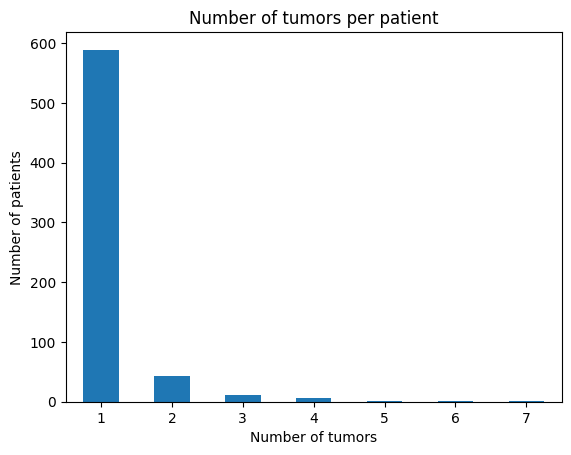

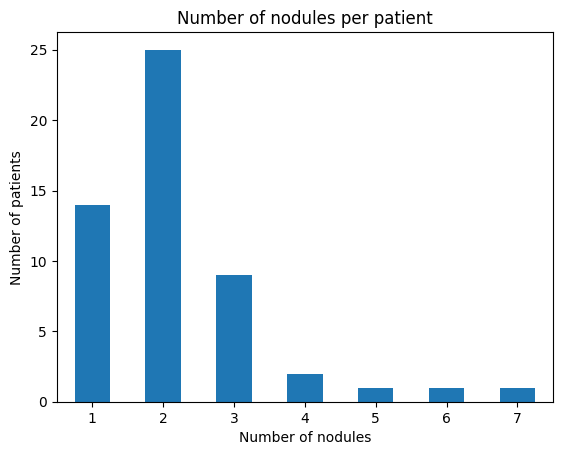

In [35]:
# See how often we have multiple lesions for the patients
# plot - x axis - number of lesions, y axis - number of patients

df_label_plot = df_label.copy(deep=True)
df_label_plot = df_label_plot[['ID', 'Mark_labels', 'labels_type']]
df_label_plot_1 = df_label_plot[df_label_plot['labels_type']==1] # tumor
df_label_plot_2 = df_label_plot[df_label_plot['labels_type']==2] # nodule

counts = df_label_plot_1['Mark_labels'].value_counts()
counts = counts.sort_index()
counts.plot(kind='bar', rot=0)
plt.xlabel('Number of tumors')
plt.ylabel('Number of patients')
plt.title('Number of tumors per patient')
plt.show()

counts = df_label_plot_2['Mark_labels'].value_counts()
counts = counts.sort_index()
counts.plot(kind='bar', rot=0)
plt.xlabel('Number of nodules')
plt.ylabel('Number of patients')
plt.title('Number of nodules per patient')
plt.show()

# Organize metadata

In [36]:
# Replace the nan with Neoplasm, for now

df_patient = df_patient.fillna("Neoplasm")

In [37]:
# Create one df that is joined with the SNOMED codes
# de_type should be for where labels_type = 1 = tumor, where as labels_type = 2 is a nodule

### First separate the labels according to the labels_type ###

df_label_1 = df_label[df_label['labels_type']==1]
df_label_2 = df_label[df_label['labels_type']==2]

df_label_1 = df_label_1[['Mainfolder', 'ID', 'Mark_labels', 'labels_type']]
df_label_2 = df_label_2[['Mainfolder', 'ID', 'Mark_labels', 'labels_type']]

df_patient = df_patient[['Mainfolder', 'ID', 'de_type']]

df_patient_label_1 = df_label_1.merge(right=df_patient, how='left', on='ID')
df_patient_label_1 = df_patient_label_1[['Mainfolder_x', 'ID', 'Mark_labels', 'labels_type', 'de_type']]
df_patient_label_1 = df_patient_label_1.rename(columns={"Mainfolder_x": "Mainfolder"})

### Assign the Nodule to label 2 ###

df_patient_label_2 = df_label_2.copy(deep=True)
df_patient_label_2['de_type'] = "Nodule"

### Now add the codes for df_patient_label_1 ###
df_patient_label_1 = df_patient_label_1.merge(right=segments_code_mapping_df, left_on='de_type', right_on='Description')

# Drop the Description column
df_patient_label_1 = df_patient_label_1.drop(columns=['Description'])

### Now add the codes for df_patient_label_2 ###

df_patient_label_2 = df_patient_label_2.merge(right=segments_code_mapping_df, left_on='de_type', right_on="Description")

# Drop the Description column
df_patient_label_2 = df_patient_label_2.drop(columns=['Description'])

# # df_patient_label_2['CodingSchemeDesignator'] = ['SCT'] * len(df_patient_label_2)
# # df_patient_label_2['CodeValue'] = ["27925004"] * len(df_patient_label_2)
# # df_patient_label_2['CodeMeaning'] = ['Nodule'] * len(df_patient_label_2)

### Now join the dataframes again ###

df_patient_label = pd.concat([df_patient_label_1, df_patient_label_2])
df_patient_label = df_patient_label.sort_values(by=['ID', 'Mark_labels'])

print(len(df_patient_label))
print(len(list(set(df_patient_label['ID'].values))))

707
602


In [38]:
# Join the df_patient_label with the df_table - to get all IDs

df_patient_label = df_patient_label.merge(df_image, left_on='ID', right_on='ID')
print(len(df_patient_label))

707


In [39]:
# Check these values later

patient_list = df_patient_label['ID'].values
patient_list = list(dict.fromkeys(patient_list))
print(len(patient_list))

series_list = df_patient_label['SeriesInstanceUID'].values
series_list = list(dict.fromkeys(series_list))
print(len(series_list))

602
602


In [40]:
df_patient_label.head()

,Mainfolder,ID,Mark_labels,labels_type,de_type,Structure,SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator,SegmentedPropertyCategoryCodeSequence.CodeValue,SegmentedPropertyCategoryCodeSequence.CodeMeaning,SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator,...,SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator,SegmentedPropertyTypeModifierCodeSequence.CodeValue,SegmentedPropertyTypeModifierCodeSequence.CodeMeaning,SeriesInstanceUID,StudyDate,StudyInstanceUID,SeriesDescription,Manufacturer,ConvolutionKernel,kvp
0,01_LungTumor,100012,1,1,"Adenocarcinoma, NOS",adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,...,NaN,NaN,NaN,1.2.840.113654.2.55.13508825378604927579146345...,20000102,1.2.840.113654.2.55.38321092839390108338558865...,"1,OPA,SE,VZOOM,B30f,280,2,120,70,40,na",SIEMENS,B30f,120
1,01_LungTumor,100147,1,1,"Adenocarcinoma, NOS",adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,...,NaN,NaN,NaN,1.2.840.113654.2.55.15708941008648745210499888...,20000102,1.2.840.113654.2.55.31958452963320032523273261...,"1,OPA,GE,LSPLUS,STANDARD,330,2.5,140,40,0,na",GE MEDICAL SYSTEMS,STANDARD,140
2,01_LungTumor,100158,1,1,"Adenocarcinoma, NOS",adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,...,NaN,NaN,NaN,1.2.840.113654.2.55.31060976780967844152296392...,20010102,1.2.840.113654.2.55.81185422866512279860334872...,"2,OPA,GE,LS16,STANDARD,350,2.5,120,650,na,na",GE MEDICAL SYSTEMS,STANDARD,120
3,01_LungTumor,100242,1,1,Lepidic adenocarcinoma,lepidic_adenocarcinoma,SCT,49755003,Morphologically Altered Structure,NCIt,...,NaN,NaN,NaN,1.2.840.113654.2.55.38995485391900019876570761...,19990102,1.2.840.113654.2.55.22835224307907880875083018...,"0,OPA,GE,HSQX,STANDARD,290,2.5,120,56,0.1,1.5",GE MEDICAL SYSTEMS,STANDARD,120
4,01_LungTumor,100280,1,1,"Adenocarcinoma, NOS",adenocarcinoma,SCT,49755003,Morphologically Altered Structure,SCT,...,NaN,NaN,NaN,1.2.840.113654.2.55.11168439182281552750699540...,20000102,1.2.840.113654.2.55.30207427775351702734806349...,"1,OPA,SE,SEN16,B30f,282,2,120,45,30,na",SIEMENS,B30f,120


# Functions


In [41]:
json_template = {
    "BodyPartExamined": "CHEST",
    "ClinicalTrialCoordinatingCenterName": "dcmqi",
    "ClinicalTrialSeriesID": "0",
    "ClinicalTrialTimePointID": "1",
    "ContentCreatorName": "IDC",
    "ContentDescription": "Image segmentation",
    "ContentLabel": "SEGMENTATION",
    "InstanceNumber": "1",
    "SeriesDescription": "NLST Segmentation",
    "SeriesNumber": "42",
    "segmentAttributes": [
        [
            {
                "labelID": 1,
                "recommendedDisplayRGBValue": [
                    157,
                    108,
                    162
                ],
                "SegmentLabel": "Lesion", # will be the CodeMeaning
                "SegmentDescription": "Lesion", # will be CodeMeaning
                "SegmentAlgorithmType": "MANUAL",
                # "SegmentAlgorithmName": "NLSTSeg",
                "SegmentedPropertyCategoryCodeSequence": {
                    "CodingSchemeDesignator": "SCT",
                    "CodeValue": "49755003",
                    "CodeMeaning": "Morphologically Altered Structure"
                },
                "SegmentedPropertyTypeCodeSequence": {
                    "CodingSchemeDesignator": "SCT",
                    "CodeValue": "108369006",
                    "CodeMeaning": "Neoplasm"
                }
            }
        ]
    ]
}

In [42]:
def create_json_file(input_segmentation_filename,
                     df_series,
                     json_template,
                     output_json_filename):
  """
  Inputs:
    input_segmentation_filename - name of nii.gz file holding the lesion segmentation labels
    df_series                   - dataframe holding the labels to use
    json_template               - template to use for json file
    output_json_filename        - the output json filename
  """

  # First the number of labels in the segmentation_filename should equal the number of rows in the dataframe

  nii = nib.load(input_segmentation_filename)
  img = nii.get_fdata()
  seg_labels = sorted(list(np.unique(img)))
  print('seg_labels: ' + str(seg_labels))
  # ignore 0 if in list
  seg_labels.remove(0)
  num_seg_labels = len(seg_labels)
  # number of rows in dataframe
  num_rows = len(df_series)

  print('num_seg_labels: ' + str(num_seg_labels))
  print('num_rows: ' + str(num_rows))

  if (num_rows != num_seg_labels):
    print('ERROR: the number of rows in the segmentation nii file should be equal to the number of rows in the dataframe')
    return

  # Get the metadata
  SeriesNumber = df_series['SeriesNumber'].values[0]

  # Modify the SeriesNumber and SeriesDescription
  SeriesNumber_new = int(SeriesNumber*100)
  SeriesDescription_new = "NLSTSeg Segmentation of Series: " + str(SeriesNumber)

  # Modify the json file with updated SeriesNumber and SeriesDescription
  # data = json_template
  data = copy.deepcopy(json_template)
  data['SeriesNumber'] = SeriesNumber_new
  data['SeriesDescription'] = SeriesDescription_new

  # Modify the json file with the lesion metadata
  segmentAttributes_new_list = []

  for n in range(0,num_seg_labels):

    segmentAttribute_new = copy.deepcopy(json_template["segmentAttributes"][0][0])

    SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator = str(df_series['SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator'].values[n])
    SegmentedPropertyCategoryCodeSequence_CodeValue = str(df_series['SegmentedPropertyCategoryCodeSequence.CodeValue'].values[n])
    SegmentedPropertyCategoryCodeSequence_CodeMeaning = str(df_series['SegmentedPropertyCategoryCodeSequence.CodeMeaning'].values[n])

    SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator = str(df_series['SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator'].values[n])
    SegmentedPropertyTypeCodeSequence_CodeValue = str(df_series['SegmentedPropertyTypeCodeSequence.CodeValue'].values[n])
    SegmentedPropertyTypeCodeSequence_CodeMeaning = str(df_series['SegmentedPropertyTypeCodeSequence.CodeMeaning'].values[n])

    labelID = int(df_series['Mark_labels'].values[n]) # use this value instead of the seg_labels.

    segmentAttribute_new["labelID"] = labelID
    segmentAttribute_new["SegmentLabel"] = SegmentedPropertyTypeCodeSequence_CodeMeaning
    segmentAttribute_new["SegmentDescription"] = SegmentedPropertyTypeCodeSequence_CodeMeaning

    segmentAttribute_new["SegmentedPropertyCategoryCodeSequence"]["CodeValue"] = SegmentedPropertyCategoryCodeSequence_CodeValue
    segmentAttribute_new["SegmentedPropertyCategoryCodeSequence"]["CodingSchemeDesignator"] = SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator
    segmentAttribute_new["SegmentedPropertyCategoryCodeSequence"]["CodeMeaning"] = SegmentedPropertyCategoryCodeSequence_CodeMeaning

    segmentAttribute_new["SegmentedPropertyTypeCodeSequence"]["CodeValue"] = SegmentedPropertyTypeCodeSequence_CodeValue
    segmentAttribute_new["SegmentedPropertyTypeCodeSequence"]["CodingSchemeDesignator"] = SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
    segmentAttribute_new["SegmentedPropertyTypeCodeSequence"]["CodeMeaning"] = SegmentedPropertyTypeCodeSequence_CodeMeaning

    # append
    segmentAttributes_new_list.append(segmentAttribute_new)

  # Re-assign the segmentAttributes - list of lists
  # data['segmentAttributes'] = segmentAttributes_new_list
  data['segmentAttributes'] = []
  data['segmentAttributes'].append(segmentAttributes_new_list)

  # Write out the modified json file
  with open(output_json_filename, "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)


  return

In [43]:
def download_dicom_data(series_id: str) -> None:
    """
    Downloads raw DICOM data

    Args:
    series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
    """
    download_directory = os.path.join("/content/idc_data",series_id)
    # Attempt to remove the directory for the series if it exists
    try:
        shutil.rmtree(download_directory)
    except OSError:
        pass
    print(f'\n Downloading DICOM files from IDC Storage Buckets \n')
    idc_client.download_dicom_series(seriesInstanceUID= series_id, downloadDir=download_directory, dirTemplate='', quiet=False)

In [44]:
# def convert_dicom_to_nifti(series_id: str) -> None:
#     """
#     Converts a DICOM series to a NIfTI file.

#     Args:
#       series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
#     """

#     # Attempt to remove the directory for the series if it exists
#     try:
#         shutil.rmtree(os.path.join("/content/dcm2niix",series_id))
#     except OSError:
#         pass

#     # Create a new directory for the series
#     os.mkdir(os.path.join("/content/dcm2niix",series_id))

#     print("\n Converting DICOM files to NIfTI \n")

#     # Run the appropriate converter command and capture the output

#     # use just SeriesInstanceUID for the output file name to make it more readable
#     result = subprocess.run(
#         f"/usr/local/bin/dcm2niix -z y -f %j -b n -m y -o /content/dcm2niix/{series_id}/ /content/idc_data/{series_id}",
#         shell=True,
#         capture_output=True,
#         text=True,
#     )
#     print(result.stdout)
#     print("\n Conversion successful")

def convert_dicom_to_nifti_sitk(series_id: str) -> None:
    """
    Converts a DICOM series to a NIfTI file using SimpleITK.

    Args:
      series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
    """

    # Attempt to remove the directory for the series if it exists
    try:
        shutil.rmtree(os.path.join("/content/dcm2niix",series_id))
    except OSError:
        pass

    # Create a new directory for the series
    os.mkdir(os.path.join("/content/dcm2niix",series_id))

    print("\n Converting DICOM files to NIfTI \n")

    # Run the appropriate converter command and capture the output
    # use just SeriesInstanceUID for the output file name to make it more readable

    dicom_reader = sitk.ImageSeriesReader()
    if series_id is None:
      series_id = ''
    dicom_file_names = dicom_reader.GetGDCMSeriesFileNames(os.path.join("/content/idc_data", series_id),
                                                           seriesID=series_id)
    if not dicom_file_names:
      download_path = os.path.join("/content/idc_data", series_id)
      print('Directory {} is not a dicom'.format(download_path))
    dicom_reader.SetFileNames(dicom_file_names)
    dicom_image = dicom_reader.Execute()

    # Write image as nii using sitk
    output_nifti_filename = os.path.join("/content/dcm2niix", series_id, series_id + ".nii.gz")
    if not os.path.exists(os.path.join("/content/dcm2niix", series_id)):
      os.mkdir(os.path.join("/content/dcm2niix", series_id))
    sitk.WriteImage(dicom_image, output_nifti_filename)


In [45]:
# set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING)

def extract_radiomics_features_from_one_label(
    segmentation_file, image_file, label_id_body_part_df, label=None
):
    """
    Extract radiomics features from a given ct nifti image and segmentation file.

    Args:
        segmentation_file: The path to the segmentation file.
        image_file: The path to the ct nifti image file.
        label: The label of the region of interest in the segmentation file.

    Returns:
        A dictionary containing the extracted radiomics features.
    """
    body_part = label_id_body_part_df.loc[label_id_body_part_df["label_id"] == label][
        "body_part"
    ].values[0]
    print('In extract_radiomics_features_from_one_label')
    print('label: ' + str(label))
    print('body_part: ' + str(body_part))

    try:
        # Define the settings for the feature extractor

        """the tolerance value is taken from the totalsegmentator repo
        # https://github.com/wasserth/TotalSegmentator/blob/master/totalsegmentator/statistics.py#L31
        """
        settings = {"geometryTolerance": 1e-3}

        # Create the feature extractor
        extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

        # Get the list of shape and firstorder features
        shape_features = radiomics_features_code_mapping_df[
            radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "shape"
        ]["feature"].tolist()
        firstorder_features = radiomics_features_code_mapping_df[
            radiomics_features_code_mapping_df[
                "pyradiomics_feature_class"
            ]
            == "firstorder"
        ]["feature"].tolist()

        # Enable the shape and firstorder features
        extractor.disableAllFeatures()
        extractor.enableFeaturesByName(
            # NB: while testing, use the line below to reduce the number of features to be extracted
            # firstorder=firstorder_features[:3]
            firstorder=firstorder_features, shape=shape_features
        )
        # Extract the features
        raw_features = extractor.execute(
            str(image_file), str(segmentation_file), label=label
        )

        # Clean the feature names and round the values
        cleaned_features = {
            name.replace("original_", ""): round(float(value), 4)
            for name, value in raw_features.items()
            if name.startswith("original_")
        }
        mask_stats = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in cleaned_features.items()
        }
    except Exception as e:
        print(
            f"WARNING: radiomics raised an exception (setting all features to 0): {e}"
        )
        cleaned_features = {feature: 0 for feature in shape_features}
        raw_features= {feature: 0 for feature in shape_features}
        mask_stats = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in cleaned_features.items()
        }
    return body_part, mask_stats, raw_features

In [46]:
def extract_features_for_all_labels(ct_file: Path, seg_file: Path, output_file: Path, output_json_filename: str):
    """
    Extract radiomics features from a given image and segmentation file for all labels, and map the label numbers to names.

    Args:
        ct_file: The path to the CT Nifti image file.
        seg_file: The path to the segmentation file.
        output_file: The path to the output file where the results will be saved.
        output_json_filename: The json filename used from creating the associated DICOM SEG file

    Returns:
        None. The results are saved to the output file.
    """
    # # Map the label IDs to body part names
    # label_id_body_part_data = map_to_binary.class_map["total_v1"].items()
    # label_id_body_part_df = pd.DataFrame(
    #     label_id_body_part_data, columns=["label_id", "body_part"]
    # )
    label_id_body_part_df = pd.DataFrame()
    # label_id_body_part_df["body_part"] = segments_code_mapping_df["Structure"].values

    # Since the label ids in the segmentation file don't map to the names,
    # we need to input the actual json file from the DICOM SEG file
    # And since the lesions are on a patient level, and not a lesion level, will all have the same type
    with open(output_json_filename, 'r') as file:
      seg_json = json.load(file)
    # body_part = SegmentLabel names
    body_part = [f['SegmentLabel'] for f in seg_json['segmentAttributes'][0]]
    # now find corresponding names from segments_code_mapping_df['Structure']
    body_part_mapping_dict = {}
    keys = segments_code_mapping_df['SegmentedPropertyTypeCodeSequence.CodeMeaning'].values
    values = segments_code_mapping_df['Structure'].values
    body_part_mapping_dict = {key: value for key, value in zip(keys, values)}
    # label_id_body_part_df['body_part'] = body_part
    label_id_body_part_df['body_part'] = [body_part_mapping_dict[f] for f in body_part]

    # label_id_body_part_df["label_id"] = [1] * len(label_id_body_part_df)
    label_id_body_part_df["label_id"] = list(np.arange(1,len(label_id_body_part_df)+1))
    print('label_id_body_part_df: ' + str(label_id_body_part_df))

    # Initialize an empty dictionary to store the results
    stats = {}
    raw_stats = {}

    # Get the list of unique labels in the segmentation file
    labels = [
        int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0
    ]
    print('labels: ' + str(labels))

    # Define the function to be applied to each label
    func = partial(
        extract_radiomics_features_from_one_label,
        seg_file,
        ct_file,
        label_id_body_part_df,
    )

    # if not is_series_greater_than_800_slices(series_id):
    #     # Use a multiprocessing pool to apply the function to all labels
    #     with multiprocessing.Pool() as pool:
    #         results = list(tqdm(pool.imap(func, labels), total=len(labels)))
    # else:
    #     # Apply the function to all labels sequentially
    #     results = [func(label) for label in tqdm(labels)]
    results = [func(label) for label in tqdm(labels)]

    print('results: ' + str(results))

    # Process the results
    # This needs to be per label_id not per body_part - since we can have multiple of the same body part!
    label_index = 1
    for body_part, mask_stats, raw_features in results:
      print("label_index: " + str(index))
      print('body_part: ' + str(body_part))
      print('mask_stats: ' + str(mask_stats))
      print('raw_features: ' + str(raw_features))
      if any(v != 0 for v in mask_stats.values()):
          # stats[body_part] = mask_stats
          # raw_stats[body_part] = raw_features
          stats[label_index] = mask_stats
          raw_stats[label_index] = raw_features
          label_index += 1

    # Save the results to the output file
    with open(output_file, "w") as f:
        json.dump(stats, f, indent=4)
    try:
        # Save the raw features to a separate output file
        with open(output_file.rsplit(".", 1)[0] + "_raw.json", "w") as f:
            json.dump(raw_stats, f, indent=4, default=ndarray_to_list)
    except:
        log_failed_to_save_raw_radiomics_features(series_id)

In [47]:
def ndarray_to_list(obj):

    """Convert a numpy array to a list.
       Helps for saving raw radiomics in a json file

    Args:
      obj: A numpy array.

    Returns:
      A list representation of the numpy array.
    """

    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

In [48]:
def log_failed_to_save_raw_radiomics_features(series_id: str) -> None:
    """
    Log an error message when the raw radiomics features for a given series fail to save.

    Args:
        series_id: The ID of the series.

    Returns:
        None. The error message is written to a log file.
    """
    # Define the path to the log file
    log_file_path = '/content/radiomics_error_file.txt'

    # Define the error message
    error_message = f"Error: Failed to save raw radiomics features for series {series_id}\n"

    # Append the error message to the log file
    with open(log_file_path, 'a') as f:
        f.write(error_message)

In [49]:
def setup_and_trigger_extraction_of_radiomics_features_all_labels(series_id: str,
                                                                  output_json_filename: str):
    """
    Compute radiomics features for all labels in a given series.
    This function calls `extract_features_for_all_labels` with
    the expected file paths of ct nifti and segmentation nifti
    files.

    Args:
        series_id: The ID of the series.

    Returns:
        None. The results are saved to a file.
    """
    # Define the paths
    inference_nifti_path = os.path.join(
        "/content/Inference", series_id, f"{series_id}.nii.gz"
    )

    # Get the full path of the CT Nifti file
    ct_series_id_folder_path = os.path.join("/content/dcm2niix", series_id)
    # Get the list of files in series_id_path
    ct_nifti_files = os.listdir(ct_series_id_folder_path)
    # Get the first (and only) file in the list
    ct_nifti_filename = ct_nifti_files[0]
    # Get the full path of the file
    ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)

    # Define the output filename
    output_filename = os.path.join(
        "/content/radiomics", series_id, f"{series_id}_radiomics.json"
    )
    if not os.path.isdir(os.path.join("/content/radiomics", series_id)):
      os.mkdir(os.path.join("/content/radiomics", series_id))

    # Record the start time
    start_time = time.time()

    # Compute the radiomics features for all labels
    extract_features_for_all_labels(
        ct_nifti_filename_path, inference_nifti_path, output_filename, output_json_filename
    )

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    print(f"Radiomics Features Calculation Done in {elapsed_time} seconds.")

In [50]:
def verify_radiomics_extraction(series_id: str):
    """
    Verify if the radiomics feature extraction was successful for a given series.

    Args:
        series_id: The ID of the series.

    Returns:
        A boolean indicating whether the radiomics feature extraction failed.
    """
    # Define the path to the output file
    output_file_path = os.path.join('/content/radiomics',series_id, f"{series_id}_radiomics.json")

    try:
        # Check if the output file exists
        assert os.path.exists(output_file_path)
    except AssertionError:
        # If the output file does not exist, log an error and return True
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True

    # If the output file exists, return False
    return False

In [51]:
# def post_process_radiomics_features(series_id: str):
#     """
#     Post-process the computed radiomics features for a given series.

#     In dicom seg objects, segment numbers should be continuous,
#     so label numbers cannot be used as we may not always see all
#     labels

#     Args:
#         series_id: The ID of the series.

#     Returns:
#         A DataFrame containing the processed radiomics features.
#     """
#     # Define the path to the JSON file containing the radiomics features
#     json_path = os.path.join('/content/radiomics', series_id, f'{series_id}_radiomics.json')

#     # Load the JSON file into a DataFrame
#     radiomics_df = pd.read_json(json_path, orient='index')

#     # Rename the columns by splitting on underscores and taking the last part
#     radiomics_df = radiomics_df.rename(columns=lambda x: x.split('_')[-1])

#     # Reset the index and rename the index column to 'body_part'
#     radiomics_df = radiomics_df.reset_index().rename(columns={'index': 'body_part'})

#     # Create a DataFrame from the class map
#     class_map_df = pd.DataFrame(map_to_binary.class_map['total_v1'].items(), columns=['label_id', 'body_part'])

#     # Merge the radiomics DataFrame with the class map DataFrame
#     radiomics_df = pd.merge(radiomics_df, class_map_df, on='body_part')

#     # Sort the 'label_id' column and create a 'seg_segment_number' column
#     radiomics_df = radiomics_df.assign(
#         label_id=radiomics_df['label_id'].astype(int).sort_values(),
#         seg_segment_number=range(1, len(radiomics_df) + 1)
#     )

#     # Reorder the columns
#     columns = ['body_part', 'seg_segment_number', 'label_id'] + [col for col in radiomics_df.columns if col not in ['body_part', 'seg_segment_number', 'label_id']]
#     radiomics_df = radiomics_df[columns]
#     '''
#     in IBSI kurtosis is subracted by 3 units
#     https://pubs.rsna.org/doi/suppl/10.1148/radiol.2020191145/suppl_file/IBSI_Reference_Manual.pdf#.3.4%20(Excess)%20intensity%20kurtosis
#     '''
#     if 'Kurtosis' in radiomics_df.columns:
#       radiomics_df['Kurtosis']=radiomics_df['Kurtosis']-3

#     return radiomics_df


def post_process_radiomics_features(series_id: str, df_series):
    """
    Post-process the computed radiomics features for a given series.

    In dicom seg objects, segment numbers should be continuous,
    so label numbers cannot be used as we may not always see all
    labels

    Args:
        series_id: The ID of the series.

    Returns:
        A DataFrame containing the processed radiomics features.
    """
    # Define the path to the JSON file containing the radiomics features
    json_path = os.path.join('/content/radiomics', series_id, f'{series_id}_radiomics.json')

    # Load the JSON file into a DataFrame
    radiomics_df = pd.read_json(json_path, orient='index')

    # Rename the columns by splitting on underscores and taking the last part
    radiomics_df = radiomics_df.rename(columns=lambda x: x.split('_')[-1])

    # Reset the index and rename the index column to 'body_part'
    radiomics_df = radiomics_df.reset_index().rename(columns={'index': 'body_part'})

    # DK - change this. Need to reassign because there could be multiple of the same body parts.
    body_part = df_series['Structure'].values
    radiomics_df['body_part'] = body_part

    # # Create a DataFrame from the class map
    # class_map_df = pd.DataFrame(map_to_binary.class_map['total_v1'].items(), columns=['label_id', 'body_part'])

    # # Merge the radiomics DataFrame with the class map DataFrame
    # radiomics_df = pd.merge(radiomics_df, class_map_df, on='body_part')

    # I add this in because for NLSTSeg the label_id is equal to the number of tumors
    radiomics_df['label_id'] = list(np.arange(1,len(radiomics_df)+1))

    # Sort the 'label_id' column and create a 'seg_segment_number' column
    radiomics_df = radiomics_df.assign(
        label_id=radiomics_df['label_id'].astype(int).sort_values(),
        seg_segment_number=range(1, len(radiomics_df) + 1)
    )

    # Reorder the columns
    columns = ['body_part', 'seg_segment_number', 'label_id'] + [col for col in radiomics_df.columns if col not in ['body_part', 'seg_segment_number', 'label_id']]
    radiomics_df = radiomics_df[columns]
    '''
    in IBSI kurtosis is subracted by 3 units
    https://pubs.rsna.org/doi/suppl/10.1148/radiol.2020191145/suppl_file/IBSI_Reference_Manual.pdf#.3.4%20(Excess)%20intensity%20kurtosis
    '''
    if 'Kurtosis' in radiomics_df.columns:
      radiomics_df['Kurtosis']=radiomics_df['Kurtosis']-3

    return radiomics_df

In [52]:
# Define the segment code mapping DataFrame and feature code mapping DataFrames
shape_features_code_mapping_df = (
    radiomics_features_code_mapping_df[
        radiomics_features_code_mapping_df[
            "pyradiomics_feature_class"
        ]
        == "shape"
    ]
)
first_order_features_code_mapping_df = (
    radiomics_features_code_mapping_df[
        radiomics_features_code_mapping_df[
            "pyradiomics_feature_class"
        ]
        == "firstorder"
    ]
)

In [53]:
def create_structured_report_metajson_for_features(
    SeriesInstanceUID,
    series_number,
    SOPInstanceUID_seg,
    seg_file,
    dcm_directory,
    segments_code_mapping_df,
    features_code_mapping_df,
    radiomics_features,
):

    """Function that creates the metajson necessary for the creation of a
    structured report from a pandas dataframe of label names and features for
    each.

    Inputs:
      SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT
                                        file
      series_number                    : SeriesNumber of the corresponding CT file
      SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file
      seg_file                        : filename of SEG DCM file
      dcm_directory                   : ct directory
      segments_code_mapping_df        : dataframe that holds the names of the
                                        segments and the associated code values etc.
      features_code_mapping_df        : dataframe that holds the names of the
                                        features and the associated code values etc.
      df_features                     : a pandas dataframe holding the segments and a
                                        set of 3D shape features for each

    Outputs:
      Returns the metajson for the structured report that will then be used by
      dcmqi tid1500writer to create a structured report
    """

    # --- Get the version number for the pyradiomics package --- #

    pyradiomics_version_number = str(radiomics.__version__)

    image_library= [os.path.basename(f) for f in os.listdir(dcm_directory)]

    # --- Create the header for the json --- #

    inputMetadata = {}
    inputMetadata[
        "@schema"
    ] = "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
    inputMetadata["SeriesDescription"] = (
        "NLSTSeg "
        + features_code_mapping_df["pyradiomics_feature_class"].iloc[0]
        + " Measurements of series "
        + str(series_number)
    )
    if series_number:
        inputMetadata["SeriesNumber"] = str(1 + int(series_number) * 100)
    inputMetadata["InstanceNumber"] = "1"

    inputMetadata["compositeContext"] = [seg_file]

    inputMetadata["imageLibrary"] = image_library
    inputMetadata["observerContext"] = {
        "ObserverType": "DEVICE",
        "DeviceObserverName": "pyradiomics",
        "DeviceObserverModelName": pyradiomics_version_number,
    }

    inputMetadata["VerificationFlag"] = "UNVERIFIED"
    inputMetadata["CompletionFlag"] = "COMPLETE"
    inputMetadata["activitySession"] = "1"
    inputMetadata["timePoint"] = "1"

    # ------------------------------------------------------------------------- #
    # --- Create the measurement_dict for each segment - holds all features --- #

    measurement = []

    # --- Now create the dict for all features and all segments --- #

    # --- Loop over the number of segments --- #

    # number of rows in the df_features
    num_segments = radiomics_features.shape[0]
    print('num_segments: ' + str(num_segments))

    # Array of dictionaries - one dictionary for each segment
    measurement_across_segments_combined = []

    for segment_id in range(0, num_segments):

        # ReferencedSegment = int(
        #     radiomics_features["seg_segment_number"].values[segment_id]
        # )  # referencedsegment must be an integer according to the schema.
        # FindingSite = radiomics_features["body_part"].values[segment_id]

        ReferencedSegment = segment_id + 1
        FindingSite = radiomics_features["body_part"].values[segment_id]
        print('ReferencedSegment: ' + str(ReferencedSegment))
        print('FindingSite: ' + str(FindingSite))

        # --- Create the dict for the Measurements group --- #
        TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

        segment_row = segments_code_mapping_df[
            segments_code_mapping_df["Structure"] == FindingSite
        ]
        # print("segment_row: " + str(segment_row))

        # Inside the loop for each segment
        my_dict = {
            "TrackingIdentifier": str(TrackingIdentifier),
            "ReferencedSegment": int(ReferencedSegment),
            "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
            "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
            "Finding": {
                "CodeValue": str(
                    segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[
                        0
                    ]
                ),
                "CodingSchemeDesignator": str(
                    segment_row[
                        "SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"
                    ].iloc[0]
                ),
                "CodeMeaning": str(
                    segment_row[
                        "SegmentedPropertyCategoryCodeSequence.CodeMeaning"
                    ].iloc[0]
                ),
            },
            "FindingSite": {
                "CodeValue": str(
                    segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]
                ),
                "CodingSchemeDesignator": str(
                    segment_row[
                        "SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"
                    ].iloc[0]
                ),
                "CodeMeaning": str(
                    segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]
                ),
            },
            "measurementAlgorithmIdentification": {
                "AlgorithmName": "pyradiomics",
                "AlgorithmVersion": str(pyradiomics_version_number)
            }
        }

        laterality_dict = {
            "CodeValue": str(
                segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[
                    0
                ]
            ),
            "CodingSchemeDesignator": str(
                segment_row[
                    "SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"
                ].iloc[0]
            ),
            "CodeMeaning": str(
                segment_row[
                    "SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"
                ].iloc[0]
            ),
        }

        # Append the remaining code after creating the measurement_across_segments_combined array
        # Check if the laterality dictionary is empty or contains NaN values
        if laterality_dict and not any(
            value == "nan" or pd.isna(value) for value in laterality_dict.values()
        ):
            my_dict["Laterality"] = laterality_dict

        measurement = []
        # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
        # num_values = len(radiomics_features.columns) - 2
        num_values = len(radiomics_features.columns) - 3

        # feature_list = radiomics_features.columns[2:] # remove first two
        feature_list = features_code_mapping_df.feature.to_list()

        # For each measurement per region segment
        for n in range(0, len(feature_list)):
            if not feature_list[n] in radiomics_features.columns:
                print("failed to find feature "+features_code_mapping_df["feature"]+" - skipping")
                continue
            measurement_dict = {}
            row = radiomics_features.loc[radiomics_features["body_part"] == FindingSite]
            feature_row = features_code_mapping_df.loc[
                features_code_mapping_df["feature"] == feature_list[n]
            ]
            # continue if feature_row is empty
            if row.empty:
                print("failed to find feature "+features_code_mapping_df["feature"])
                continue

            value = str(np.round(row[feature_list[n]].values[0], 3))
            measurement_dict["value"] = value
            measurement_dict["quantity"] = {}
            measurement_dict["quantity"]["CodeValue"] = str(
                feature_row["quantity_CodeValue"].values[0]
            )
            measurement_dict["quantity"]["CodingSchemeDesignator"] = str(
                feature_row["quantity_CodingSchemeDesignator"].values[0]
            )
            measurement_dict["quantity"]["CodeMeaning"] = str(
                feature_row["quantity_CodeMeaning"].values[0]
            )
            measurement_dict["units"] = {}
            measurement_dict["units"]["CodeValue"] = str(
                feature_row["units_CodeValue"].values[0]
            )
            measurement_dict["units"]["CodingSchemeDesignator"] = str(
                feature_row["units_CodingSchemeDesignator"].values[0]
            )
            measurement_dict["units"]["CodeMeaning"] = str(
                feature_row["units_CodeMeaning"].values[0]
            )
            measurement.append(measurement_dict)

        measurement_combined_dict = {}
        measurement_combined_dict[
            "measurementItems"
        ] = measurement  # measurement is an array of dictionaries

        output_dict_one_segment = {**my_dict, **measurement_combined_dict}

        # append to array for all segments

        measurement_across_segments_combined.append(output_dict_one_segment)

    # --- Add the measurement data --- #

    inputMetadata["Measurements"] = {}
    inputMetadata["Measurements"] = measurement_across_segments_combined
    feature_type = features_code_mapping_df["pyradiomics_feature_class"].iloc[0]
    if not os.path.isdir(os.path.join("/content/structuredReportsJSON", series_id)):
      os.makedirs(os.path.join("/content/structuredReportsJSON", series_id), exist_ok=True)
    sr_json_path = os.path.join("/content/structuredReportsJSON", series_id, series_id + '_' + feature_type + "_sr.json")
    if not os.path.isdir(os.path.join("/content/structuredReportsDICOM", series_id)):
      os.makedirs(os.path.join("/content/structuredReportsDICOM", series_id), exist_ok=True)
    sr_path = os.path.join("/content/structuredReportsDICOM", series_id, series_id + '_' + feature_type + "_sr.dcm")
    pred_dicomseg_path = os.path.join("/content/itkimage2segimage", series_id)

    with open(sr_json_path, "w") as f:
        json.dump(inputMetadata, f, indent=2)
        print(f"wrote out json for {feature_type} features")

    inputImageLibraryDirectory = dcm_directory
    # outputDICOM = sr_json_path
    outputDICOM = sr_path
    # the name of the folder where the seg files are located
    inputCompositeContextDirectory = pred_dicomseg_path
    inputMetadata_json = sr_json_path

    print("inputImageLibraryDirectory: " + str(inputImageLibraryDirectory))
    print("outputDICOM: " + str(outputDICOM))
    print("inputCompositeContextDirectory: " + str(inputCompositeContextDirectory))
    print("inputMetadata_json: " + str(inputMetadata_json))
    try:
      !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
                    --outputDICOM $outputDICOM  \
                    --inputCompositeContextDirectory $inputCompositeContextDirectory \
                    --inputMetadata $sr_json_path
      print(f"wrote out SR for {feature_type} radiomics features\n")
    except:
      print("ERROR: failed to save the SR ")

# Create DICOM SEG and SRs

In [54]:
dicom_directory = "/content/idc_data"
if not os.path.isdir(dicom_directory):
  os.mkdir(dicom_directory)

# Directory for DICOM SEG
seg_directory = "/content/itkimage2segimage/"
if not os.path.isdir(seg_directory):
  os.mkdir(seg_directory)

if not os.path.isdir("/content/dcm2niix/"):
  os.mkdir("/content/dcm2niix/")

if not os.path.isdir("/content/radiomics/"):
  os.mkdir("/content/radiomics/")

if not os.path.isdir("/content/Inference/"):
  os.mkdir("/content/Inference/")

# Get list of SeriesInstanceUIDs
SeriesInstanceUID_list = df_patient_label['SeriesInstanceUID'].values
SeriesInstanceUID_list = list(dict.fromkeys(SeriesInstanceUID_list))
print(len(SeriesInstanceUID_list))

602


In [55]:
# Print checkpoint
checkpoints = {int(len(SeriesInstanceUID_list) * i / 10) for i in range(1, 11)}

### LOOP over the series ###

for index, SeriesInstanceUID in enumerate(SeriesInstanceUID_list[0:10],1):

  # Get the dataframe subset
  df_series = df_patient_label[df_patient_label['SeriesInstanceUID']==str(SeriesInstanceUID)]

  # Get the PatientID
  PatientID = str(df_series['ID'].values[0])

  series_id = SeriesInstanceUID

  # Download DICOM data
  download_dicom_data(series_id)

  # Convert DICOM to NIfTI
  if not os.path.isdir(os.path.join("/content/dcm2niix", series_id)):
    os.mkdir(os.path.join("/content/dcm2niix", series_id))
  # convert_dicom_to_nifti(series_id)
  convert_dicom_to_nifti_sitk(series_id)
  print("ct nii filename: " + os.path.join("/content/dcm2niix", series_id, series_id + ".nii.gz"))
  print('ct nii file exists: ' + str(os.path.exists(os.path.join("/content/dcm2niix", series_id, series_id + ".nii.gz"))))

  # Get the SeriesNumber from one of the DICOM files
  sample_dicom_filename = os.path.join("/content/idc_data", series_id,
                                       os.listdir(os.path.join("/content/idc_data", series_id))[0])
  print('sample_dicom_filename: ' + str(sample_dicom_filename))
  dcm = pydicom.dcmread(sample_dicom_filename, stop_before_pixels=True)
  SeriesNumber = dcm.SeriesNumber
  # Add to dataframe
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)

  series_number = SeriesNumber

  ### Create the json metadata file automatically ###
  # For now we assume the lesion information is on a patient/series level
  print('Create json metadata file for dcmqi')

  # First copy from bucket to local
  seg_filename_bucket = os.path.join(input_bucket, 'data', PatientID + '_tumor.nii.gz')
  seg_filename = os.path.join("/content/", PatientID + "_tumor.nii.gz")
  !gsutil cp $seg_filename_bucket $seg_filename

  # Then copy from local to renamed
  inference_nifti_filename = os.path.join(
        "/content/Inference", series_id, series_id + ".nii.gz"
    )
  if not os.path.isdir(os.path.join("/content/Inference/", series_id)):
    os.mkdir(os.path.join("/content/Inference", series_id))
  !cp $seg_filename $inference_nifti_filename

  output_json_filename = "/content/seg.json"
  create_json_file(inference_nifti_filename,
                   df_series,
                   json_template,
                   output_json_filename)

  ### Set output DICOM SEG filename ###
  print ('Create DICOM SEG file')
  dicom_segmentation_filename = os.path.join(seg_directory, SeriesInstanceUID, SeriesInstanceUID + ".dcm")
  if not os.path.isdir(os.path.join(seg_directory, SeriesInstanceUID)):
    os.mkdir(os.path.join(seg_directory, SeriesInstanceUID))

  print('dicom_segmentation_filename: ' + str(dicom_segmentation_filename))
  dicom_directory_series = os.path.join("/content/idc_data", series_id)
  !itkimage2segimage --inputImageList $inference_nifti_filename --inputDICOMDirectory $dicom_directory_series --outputDICOM $dicom_segmentation_filename --inputMetadata $output_json_filename

  ### Copy DICOM SEG to bucket ###
  dicom_segmentation_filename_bucket = os.path.join(output_bucket, "seg", series_id + "_SEG.dcm")
  !gsutil cp $dicom_segmentation_filename $dicom_segmentation_filename_bucket

  ### Create DICOM SR ###

  # Setup and trigger extraction of radiomics features for all labels
  print('Extract all radiomics features')
  setup_and_trigger_extraction_of_radiomics_features_all_labels(series_id,
                                                                output_json_filename)

  # Verify radiomics feature extraction
  print('Verify radiomics features')
  verify_radiomics_extraction(series_id)

  # Post-process radiomics features
  print('Processing radiomics features')
  if not os.path.isdir(os.path.join("/content/radiomics", series_id)):
    os.mkdir(os.path.join("/content/radiomics", series_id))
  radiomics_features = post_process_radiomics_features(series_id,
                                                       df_series)

  # Read the DICOM segmentation file
  # seg_dcm = dcmread(f"itkimage2segimage/{series_id}/{series_id}.dcm")
  seg_dcm = dcmread(dicom_segmentation_filename)

  # Get the SOPInstanceUID of the segmentation
  SOPInstanceUID_seg = seg_dcm.SOPInstanceUID

  # Define the segmentation file and DICOM directory
  # seg_file = f"{series_id}.dcm"
  # dicom_directory = f"idc_data/{series_id}"
  dicom_directory = os.path.join("/content/idc_data", series_id)
  seg_file = dicom_segmentation_filename

  # Create structured report meta-JSON for shape features
  print('Creating the SR for shape features')
  create_structured_report_metajson_for_features(
      series_id,
      series_number,
      SOPInstanceUID_seg,
      seg_file,
      dicom_directory,
      segments_code_mapping_df,
      shape_features_code_mapping_df,
      radiomics_features,
  )

  # Create structured report meta-JSON for first order features
  print('Creating the SR for first order features')
  create_structured_report_metajson_for_features(
      series_id,
      series_number,
      SOPInstanceUID_seg,
      seg_file,
      dicom_directory,
      segments_code_mapping_df,
      first_order_features_code_mapping_df,
      radiomics_features,
  )

  ### Copy DICOM SRs to bucket ###
  sr_shape_filename = os.path.join("/content/structuredReportsDICOM/", series_id, series_id + "_firstorder_sr.dcm")
  sr_first_order_filename = os.path.join("/content/structuredReportsDICOM/", series_id, series_id + "_shape_sr.dcm")
  sr_shape_filename_bucket = os.path.join(output_bucket, 'sr_shape', series_id + "_sr.dcm")
  sr_first_order_filename_bucket = os.path.join(output_bucket, 'sr_first_order', series_id + "_sr.dcm")
  !gsutil cp $sr_shape_filename $sr_shape_filename_bucket
  !gsutil cp $sr_first_order_filename $sr_first_order_filename_bucket

  ### Delete DICOM data, SEG, SRs ###
  temp_inference_directory = os.path.join("/content/Inference", series_id)
  temp_dicom_directory = os.path.join("/content/idc_data", series_id)
  temp_nii_directory = os.path.join("/content/dcm2niix", series_id)
  temp_seg_directory = os.path.join("/content/itkimage2segimage", series_id)
  temp_radiomics_directory = os.path.join("/content/radiomics/", series_id)
  temp_sr_dicom_directory = os.path.join("/content/structuredReportsDICOM", series_id)
  temp_sr_json_directory = os.path.join("/content/structuredReportsJSON", series_id)
  !rm -rf $temp_inference_directory
  !rm -rf $temp_dicom_directory
  !rm -rf $temp_nii_directory
  !rm -rf $temp_seg_directory
  !rm -rf $temp_radiomics_directory
  !rm -rf $temp_sr_dicom_directory
  !rm -rf $temp_sr_json_directory
  !rm $seg_filename

  if index in checkpoints:
    print(f"{(index / len(SeriesInstanceUID_list)) * 100:.0f}% of series processed.")




 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.135088253786049275791463451273034430925/1.2.840.113654.2.55.135088253786049275791463451273034430925.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.135088253786049275791463451273034430925/132b919c-7859-410c-869c-3af7e0cc0a37.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100012_tumor.nii.gz...
/ [1 files][ 79.7 KiB/ 79.7 KiB]                                                
Operation completed over 1 objects/79.7 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.135088253786049275791463451273034430925/1.2.840.113654.2.55.135088253786049275791463451273034430925.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.135088253786049275791463451273034430925/1.2.840.113654.2.55.135088253786049275791463451273034430925.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.135088253786049275791463451273034430925 for DICOM files
157 of 157 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: adenocarcinoma


100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

results: [('adenocarcinoma', {'shape_Elongation': 0.9648, 'shape_Flatness': 0.5145, 'shape_LeastAxisLength': 14.2908, 'shape_MajorAxisLength': 27.7758, 'shape_Maximum3DDiameter': 35.8756, 'shape_MeshVolume': 5796.3694, 'shape_MinorAxisLength': 26.7973, 'shape_Sphericity': 0.5124, 'shape_SurfaceArea': 3045.2585, 'shape_SurfaceVolumeRatio': 0.5254, 'shape_VoxelVolume': 5840.8813, 'firstorder_10Percentile': -783.0, 'firstorder_90Percentile': -41.0, 'firstorder_Energy': 2804712787.0, 'firstorder_Entropy': 5.3118, 'firstorder_InterquartileRange': 419.0, 'firstorder_Maximum': 147.0, 'firstorder_MeanAbsoluteDeviation': 226.6931, 'firstorder_Mean': -463.0764, 'firstorder_Median': -511.0, 'firstorder_Minimum': -1021.0, 'firstorder_Range': 1168.0, 'firstorder_RobustMeanAbsoluteDeviation': 171.797, 'firstorder_RootMeanSquared': 535.93, 'firstorder_Skewness': 0.4092, 'firstorder_Uniformity': 0.0273, 'firstorder_Variance': 72781.2237, 'firstorder_Kurtosis': 2.1661}, OrderedDict({'diagnostics_Versio

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.135088253786049275791463451273034430925
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.135088253786049275791463451273034430925/1.2.840.113654.2.55.135088253786049275791463451273034430925_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.135088253786049275791463451273034430925
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.135088253786049275791463451273034430925/1.2.840.113654.2.55.135088253786049275791463451273034430925_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.1350882537860492757914634512


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.157089410086487452104998883963678895145/1.2.840.113654.2.55.157089410086487452104998883963678895145.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.157089410086487452104998883963678895145/9cb49063-c175-40c7-bc36-48727bbbcd54.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100147_tumor.nii.gz...
/ [1 files][ 58.6 KiB/ 58.6 KiB]                                                
Operation completed over 1 objects/58.6 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.157089410086487452104998883963678895145/1.2.840.113654.2.55.157089410086487452104998883963678895145.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.157089410086487452104998883963678895145/1.2.840.113654.2.55.157089410086487452104998883963678895145.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.157089410086487452104998883963678895145 for DICOM files
116 of 116 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: adenocarcinoma


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

results: [('adenocarcinoma', {'shape_Elongation': 0.9269, 'shape_Flatness': 0.6864, 'shape_LeastAxisLength': 16.2493, 'shape_MajorAxisLength': 23.6748, 'shape_Maximum3DDiameter': 32.771, 'shape_MeshVolume': 4751.0226, 'shape_MinorAxisLength': 21.9447, 'shape_Sphericity': 0.5901, 'shape_SurfaceArea': 2316.0304, 'shape_SurfaceVolumeRatio': 0.4875, 'shape_VoxelVolume': 4796.0265, 'firstorder_10Percentile': -802.0, 'firstorder_90Percentile': -349.7, 'firstorder_Energy': 1683914269.0, 'firstorder_Entropy': 4.7778, 'firstorder_InterquartileRange': 252.0, 'firstorder_Maximum': -31.0, 'firstorder_MeanAbsoluteDeviation': 139.1142, 'firstorder_Mean': -579.1929, 'firstorder_Median': -582.0, 'firstorder_Minimum': -973.0, 'firstorder_Range': 942.0, 'firstorder_RobustMeanAbsoluteDeviation': 100.9289, 'firstorder_RootMeanSquared': 603.8555, 'firstorder_Skewness': 0.2435, 'firstorder_Uniformity': 0.0407, 'firstorder_Variance': 29176.9989, 'firstorder_Kurtosis': 2.5688}, OrderedDict({'diagnostics_Versi

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.157089410086487452104998883963678895145
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.157089410086487452104998883963678895145/1.2.840.113654.2.55.157089410086487452104998883963678895145_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.157089410086487452104998883963678895145
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.157089410086487452104998883963678895145/1.2.840.113654.2.55.157089410086487452104998883963678895145_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.1570894100864874521049988839


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.310609767809678441522963921292898109470/1.2.840.113654.2.55.310609767809678441522963921292898109470.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.310609767809678441522963921292898109470/471ad39c-635e-4e02-982e-15e228bf9bc5.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100158_tumor.nii.gz...
/ [1 files][ 73.1 KiB/ 73.1 KiB]                                                
Operation completed over 1 objects/73.1 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.310609767809678441522963921292898109470/1.2.840.113654.2.55.310609767809678441522963921292898109470.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.310609767809678441522963921292898109470/1.2.840.113654.2.55.310609767809678441522963921292898109470.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.310609767809678441522963921292898109470 for DICOM files
146 of 146 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: adenocarcinoma


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]

results: [('adenocarcinoma', {'shape_Elongation': 0.7299, 'shape_Flatness': 0.71, 'shape_LeastAxisLength': 10.0568, 'shape_MajorAxisLength': 14.1651, 'shape_Maximum3DDiameter': 17.6207, 'shape_MeshVolume': 1005.0081, 'shape_MinorAxisLength': 10.3393, 'shape_Sphericity': 0.8098, 'shape_SurfaceArea': 599.1625, 'shape_SurfaceVolumeRatio': 0.5962, 'shape_VoxelVolume': 1022.454, 'firstorder_10Percentile': -659.7, 'firstorder_90Percentile': 15.7, 'firstorder_Energy': 150320142.0, 'firstorder_Entropy': 4.9173, 'firstorder_InterquartileRange': 461.0, 'firstorder_Maximum': 84.0, 'firstorder_MeanAbsoluteDeviation': 230.498, 'firstorder_Mean': -264.7057, 'firstorder_Median': -191.0, 'firstorder_Minimum': -843.0, 'firstorder_Range': 927.0, 'firstorder_RobustMeanAbsoluteDeviation': 189.4028, 'firstorder_RootMeanSquared': 370.6807, 'firstorder_Skewness': -0.4776, 'firstorder_Uniformity': 0.0408, 'firstorder_Variance': 67335.0614, 'firstorder_Kurtosis': 1.8391}, OrderedDict({'diagnostics_Versions_PyR

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.310609767809678441522963921292898109470
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.310609767809678441522963921292898109470/1.2.840.113654.2.55.310609767809678441522963921292898109470_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.310609767809678441522963921292898109470
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.310609767809678441522963921292898109470/1.2.840.113654.2.55.310609767809678441522963921292898109470_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.3106097678096784415229639212


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.38995485391900019876570761037952058249/1.2.840.113654.2.55.38995485391900019876570761037952058249.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.38995485391900019876570761037952058249/68162773-2d7e-4ed7-8a18-f75f2fd86222.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100242_tumor.nii.gz...
/ [1 files][ 61.5 KiB/ 61.5 KiB]                                                
Operation completed over 1 objects/61.5 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.38995485391900019876570761037952058249/1.2.840.113654.2.55.38995485391900019876570761037952058249.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.38995485391900019876570761037952058249/1.2.840.113654.2.55.38995485391900019876570761037952058249.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.38995485391900019876570761037952058249 for DICOM files
123 of 123 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for label

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: lepidic_adenocarcinoma


100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

results: [('lepidic_adenocarcinoma', {'shape_Elongation': 0.8403, 'shape_Flatness': 0.6401, 'shape_LeastAxisLength': 6.5275, 'shape_MajorAxisLength': 10.1969, 'shape_Maximum3DDiameter': 12.4471, 'shape_MeshVolume': 390.3593, 'shape_MinorAxisLength': 8.5687, 'shape_Sphericity': 0.7777, 'shape_SurfaceArea': 332.1461, 'shape_SurfaceVolumeRatio': 0.8509, 'shape_VoxelVolume': 401.0197, 'firstorder_10Percentile': -414.4, 'firstorder_90Percentile': -0.9, 'firstorder_Energy': 27500771.0, 'firstorder_Entropy': 4.4654, 'firstorder_InterquartileRange': 205.0, 'firstorder_Maximum': 64.0, 'firstorder_MeanAbsoluteDeviation': 126.5774, 'firstorder_Mean': -171.762, 'firstorder_Median': -139.5, 'firstorder_Minimum': -748.0, 'firstorder_Range': 812.0, 'firstorder_RobustMeanAbsoluteDeviation': 87.0169, 'firstorder_RootMeanSquared': 234.5241, 'firstorder_Skewness': -0.9623, 'firstorder_Uniformity': 0.0541, 'firstorder_Variance': 25499.3574, 'firstorder_Kurtosis': 3.4285}, OrderedDict({'diagnostics_Version

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: lepidic_adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.38995485391900019876570761037952058249
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.38995485391900019876570761037952058249/1.2.840.113654.2.55.38995485391900019876570761037952058249_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.38995485391900019876570761037952058249
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.38995485391900019876570761037952058249/1.2.840.113654.2.55.38995485391900019876570761037952058249_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.38995485391900019876570761


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.111684391822815527506995408307213267492/1.2.840.113654.2.55.111684391822815527506995408307213267492.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.111684391822815527506995408307213267492/c6400507-b381-4035-9f4c-2ff6fb78051c.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100280_tumor.nii.gz...
/ [1 files][ 77.8 KiB/ 77.8 KiB]                                                
Operation completed over 1 objects/77.8 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.111684391822815527506995408307213267492/1.2.840.113654.2.55.111684391822815527506995408307213267492.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.111684391822815527506995408307213267492/1.2.840.113654.2.55.111684391822815527506995408307213267492.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.111684391822815527506995408307213267492 for DICOM files
155 of 155 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: adenocarcinoma


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

results: [('adenocarcinoma', {'shape_Elongation': 0.7732, 'shape_Flatness': 0.5333, 'shape_LeastAxisLength': 9.9892, 'shape_MajorAxisLength': 18.7305, 'shape_Maximum3DDiameter': 26.8924, 'shape_MeshVolume': 1176.1264, 'shape_MinorAxisLength': 14.4824, 'shape_Sphericity': 0.4825, 'shape_SurfaceArea': 1116.8534, 'shape_SurfaceVolumeRatio': 0.9496, 'shape_VoxelVolume': 1211.0128, 'firstorder_10Percentile': -570.0, 'firstorder_90Percentile': -8.0, 'firstorder_Energy': 278075667.0, 'firstorder_Entropy': 4.9795, 'firstorder_InterquartileRange': 365.0, 'firstorder_Maximum': 118.0, 'firstorder_MeanAbsoluteDeviation': 185.178, 'firstorder_Mean': -303.8452, 'firstorder_Median': -307.5, 'firstorder_Minimum': -911.0, 'firstorder_Range': 1029.0, 'firstorder_RobustMeanAbsoluteDeviation': 145.8695, 'firstorder_RootMeanSquared': 373.2512, 'firstorder_Skewness': -0.0667, 'firstorder_Uniformity': 0.0346, 'firstorder_Variance': 46994.5667, 'firstorder_Kurtosis': 2.1296}, OrderedDict({'diagnostics_Version

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.111684391822815527506995408307213267492
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.111684391822815527506995408307213267492/1.2.840.113654.2.55.111684391822815527506995408307213267492_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.111684391822815527506995408307213267492
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.111684391822815527506995408307213267492/1.2.840.113654.2.55.111684391822815527506995408307213267492_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.1116843918228155275069954083


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.81136962133262551156371928517766508555/1.2.840.113654.2.55.81136962133262551156371928517766508555.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.81136962133262551156371928517766508555/181a279d-9704-477c-a379-986db67e8c16.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100518_tumor.nii.gz...
/ [1 files][ 78.3 KiB/ 78.3 KiB]                                                
Operation completed over 1 objects/78.3 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.81136962133262551156371928517766508555/1.2.840.113654.2.55.81136962133262551156371928517766508555.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.81136962133262551156371928517766508555/1.2.840.113654.2.55.81136962133262551156371928517766508555.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.81136962133262551156371928517766508555 for DICOM files
154 of 154 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for label

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: small_cell_carcinoma_of_lung


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]

results: [('small_cell_carcinoma_of_lung', {'shape_Elongation': 0.8009, 'shape_Flatness': 0.63, 'shape_LeastAxisLength': 22.0982, 'shape_MajorAxisLength': 35.0771, 'shape_Maximum3DDiameter': 43.0873, 'shape_MeshVolume': 14727.2389, 'shape_MinorAxisLength': 28.094, 'shape_Sphericity': 0.6902, 'shape_SurfaceArea': 4209.8976, 'shape_SurfaceVolumeRatio': 0.2859, 'shape_VoxelVolume': 14774.9796, 'firstorder_10Percentile': -132.0, 'firstorder_90Percentile': 79.0, 'firstorder_Energy': 342502794.0, 'firstorder_Entropy': 3.305, 'firstorder_InterquartileRange': 54.0, 'firstorder_Maximum': 153.0, 'firstorder_MeanAbsoluteDeviation': 88.9215, 'firstorder_Mean': -6.9813, 'firstorder_Median': 39.0, 'firstorder_Minimum': -1024.0, 'firstorder_Range': 1177.0, 'firstorder_RobustMeanAbsoluteDeviation': 28.0526, 'firstorder_RootMeanSquared': 155.602, 'firstorder_Skewness': -3.3516, 'firstorder_Uniformity': 0.1665, 'firstorder_Variance': 24163.2498, 'firstorder_Kurtosis': 14.9294}, OrderedDict({'diagnostics

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: small_cell_carcinoma_of_lung
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.81136962133262551156371928517766508555
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.81136962133262551156371928517766508555/1.2.840.113654.2.55.81136962133262551156371928517766508555_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.81136962133262551156371928517766508555
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.81136962133262551156371928517766508555/1.2.840.113654.2.55.81136962133262551156371928517766508555_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.81136962133262551156


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.323804676332963457174235140303454945005/1.2.840.113654.2.55.323804676332963457174235140303454945005.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.323804676332963457174235140303454945005/68c0b1c2-17c5-43d3-aed0-c0c63397f044.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100570_tumor.nii.gz...
/ [1 files][ 82.1 KiB/ 82.1 KiB]                                                
Operation completed over 1 objects/82.1 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.323804676332963457174235140303454945005/1.2.840.113654.2.55.323804676332963457174235140303454945005.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.323804676332963457174235140303454945005/1.2.840.113654.2.55.323804676332963457174235140303454945005.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.323804676332963457174235140303454945005 for DICOM files
163 of 163 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: squamous_cell_carcinoma


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


results: [('squamous_cell_carcinoma', {'shape_Elongation': 0.9021, 'shape_Flatness': 0.5988, 'shape_LeastAxisLength': 14.1261, 'shape_MajorAxisLength': 23.5912, 'shape_Maximum3DDiameter': 29.7408, 'shape_MeshVolume': 4625.0326, 'shape_MinorAxisLength': 21.2821, 'shape_Sphericity': 0.6802, 'shape_SurfaceArea': 1973.7031, 'shape_SurfaceVolumeRatio': 0.4267, 'shape_VoxelVolume': 4657.8125, 'firstorder_10Percentile': -146.9, 'firstorder_90Percentile': 118.0, 'firstorder_Energy': 93753583.0, 'firstorder_Entropy': 3.9739, 'firstorder_InterquartileRange': 103.0, 'firstorder_Maximum': 303.0, 'firstorder_MeanAbsoluteDeviation': 85.7741, 'firstorder_Mean': 4.3048, 'firstorder_Median': 31.0, 'firstorder_Minimum': -500.0, 'firstorder_Range': 803.0, 'firstorder_RobustMeanAbsoluteDeviation': 45.9219, 'firstorder_RootMeanSquared': 125.4001, 'firstorder_Skewness': -1.7658, 'firstorder_Uniformity': 0.0863, 'firstorder_Variance': 15706.659, 'firstorder_Kurtosis': 6.6152}, OrderedDict({'diagnostics_Versi


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.264823538108475401141178460625066576318/1.2.840.113654.2.55.264823538108475401141178460625066576318.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.264823538108475401141178460625066576318/a65dbaeb-ee15-418f-9e58-1462cb98a05d.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100658_tumor.nii.gz...
/ [1 files][ 28.1 KiB/ 28.1 KiB]                                                
Operation completed over 1 objects/28.1 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]
num_seg_labels: 3
num_rows: 3
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.264823538108475401141178460625066576318/1.2.840.113654.2.55.264823538108475401141178460625066576318.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.264823538108475401141178460625066576318/1.2.840.113654.2.55.264823538108475401141178460625066576318.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.264823538108475401141178460625066576318 for DICOM files
111 of 111 slices mapped to source DICOM images
Found 4 label(s)
Processing label 1
Total non-empty slice

  0%|          | 0/3 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: large_cell_neuroendocrine_carcinoma


 33%|███▎      | 1/3 [00:03<00:07,  3.51s/it]

In extract_radiomics_features_from_one_label
label: 2
body_part: nodule


 67%|██████▋   | 2/3 [00:07<00:03,  3.56s/it]

In extract_radiomics_features_from_one_label
label: 3
body_part: nodule


100%|██████████| 3/3 [00:11<00:00,  3.74s/it]

results: [('large_cell_neuroendocrine_carcinoma', {'shape_Elongation': 0.7643, 'shape_Flatness': 0.647, 'shape_LeastAxisLength': 9.3574, 'shape_MajorAxisLength': 14.4631, 'shape_Maximum3DDiameter': 17.2302, 'shape_MeshVolume': 1003.2289, 'shape_MinorAxisLength': 11.0547, 'shape_Sphericity': 0.7753, 'shape_SurfaceArea': 625.0775, 'shape_SurfaceVolumeRatio': 0.6231, 'shape_VoxelVolume': 1023.5742, 'firstorder_10Percentile': -439.4, 'firstorder_90Percentile': 31.0, 'firstorder_Energy': 47668682.0, 'firstorder_Entropy': 4.5749, 'firstorder_InterquartileRange': 283.0, 'firstorder_Maximum': 104.0, 'firstorder_MeanAbsoluteDeviation': 157.2969, 'firstorder_Mean': -162.0561, 'firstorder_Median': -112.0, 'firstorder_Minimum': -668.0, 'firstorder_Range': 772.0, 'firstorder_RobustMeanAbsoluteDeviation': 119.4306, 'firstorder_RootMeanSquared': 246.5804, 'firstorder_Skewness': -0.7666, 'firstorder_Uniformity': 0.0521, 'firstorder_Variance': 34539.7035, 'firstorder_Kurtosis': 2.5789}, OrderedDict({'d

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 3
ReferencedSegment: 1
FindingSite: large_cell_neuroendocrine_carcinoma
ReferencedSegment: 2
FindingSite: nodule
ReferencedSegment: 3
FindingSite: nodule
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.264823538108475401141178460625066576318
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.264823538108475401141178460625066576318/1.2.840.113654.2.55.264823538108475401141178460625066576318_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.264823538108475401141178460625066576318
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.264823538108475401141178460625066576318/1.2.840.113654.2.55.264823538108475401141178460625066576318_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 3



 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.205550281945472033569029939587676807968/1.2.840.113654.2.55.205550281945472033569029939587676807968.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.205550281945472033569029939587676807968/052f7e05-bb32-428f-b80b-6a341e3a4339.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100681_tumor.nii.gz...
/ [1 files][ 84.4 KiB/ 84.4 KiB]                                                
Operation completed over 1 objects/84.4 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.205550281945472033569029939587676807968/1.2.840.113654.2.55.205550281945472033569029939587676807968.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.205550281945472033569029939587676807968/1.2.840.113654.2.55.205550281945472033569029939587676807968.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.205550281945472033569029939587676807968 for DICOM files
169 of 169 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: adenocarcinoma


100%|██████████| 1/1 [00:05<00:00,  5.66s/it]

results: [('adenocarcinoma', {'shape_Elongation': 0.695, 'shape_Flatness': 0.6458, 'shape_LeastAxisLength': 8.0015, 'shape_MajorAxisLength': 12.3898, 'shape_Maximum3DDiameter': 15.8093, 'shape_MeshVolume': 541.154, 'shape_MinorAxisLength': 8.6111, 'shape_Sphericity': 0.7369, 'shape_SurfaceArea': 435.822, 'shape_SurfaceVolumeRatio': 0.8054, 'shape_VoxelVolume': 553.8688, 'firstorder_10Percentile': -652.3, 'firstorder_90Percentile': -20.4, 'firstorder_Energy': 100120152.0, 'firstorder_Entropy': 5.0006, 'firstorder_InterquartileRange': 360.5, 'firstorder_Maximum': 55.0, 'firstorder_MeanAbsoluteDeviation': 186.0763, 'firstorder_Mean': -332.9299, 'firstorder_Median': -318.0, 'firstorder_Minimum': -799.0, 'firstorder_Range': 854.0, 'firstorder_RobustMeanAbsoluteDeviation': 142.4679, 'firstorder_RootMeanSquared': 399.2831, 'firstorder_Skewness': -0.0862, 'firstorder_Uniformity': 0.0331, 'firstorder_Variance': 48584.6511, 'firstorder_Kurtosis': 2.0174}, OrderedDict({'diagnostics_Versions_PyRad

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: adenocarcinoma
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.205550281945472033569029939587676807968
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.205550281945472033569029939587676807968/1.2.840.113654.2.55.205550281945472033569029939587676807968_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.205550281945472033569029939587676807968
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.205550281945472033569029939587676807968/1.2.840.113654.2.55.205550281945472033569029939587676807968_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.2055502819454720335690299395


 Converting DICOM files to NIfTI 

ct nii filename: /content/dcm2niix/1.2.840.113654.2.55.120195540527040042299100218911033592217/1.2.840.113654.2.55.120195540527040042299100218911033592217.nii.gz
ct nii file exists: True
sample_dicom_filename: /content/idc_data/1.2.840.113654.2.55.120195540527040042299100218911033592217/76a2eee1-39d7-4ce7-b68d-7bd22e6c454e.dcm
Create json metadata file for dcmqi


/tmp/ipython-input-2361297389.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SeriesNumber'] = [SeriesNumber] * len(df_series)


Copying gs://nlstseg/data/100697_tumor.nii.gz...
/ [1 files][ 73.1 KiB/ 73.1 KiB]                                                
Operation completed over 1 objects/73.1 KiB.                                     
seg_labels: [np.float64(0.0), np.float64(1.0)]
num_seg_labels: 1
num_rows: 1
Create DICOM SEG file
dicom_segmentation_filename: /content/itkimage2segimage/1.2.840.113654.2.55.120195540527040042299100218911033592217/1.2.840.113654.2.55.120195540527040042299100218911033592217.dcm
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loaded segmentation from /content/Inference/1.2.840.113654.2.55.120195540527040042299100218911033592217/1.2.840.113654.2.55.120195540527040042299100218911033592217.nii.gz
Searching recursively /content/idc_data/1.2.840.113654.2.55.120195540527040042299100218911033592217 for DICOM files
146 of 146 slices mapped to source DICOM images
Found 2 label(s)
Processing label 1
Total non-empty slices that will be encoded in SEG for 

  0%|          | 0/1 [00:00<?, ?it/s]

In extract_radiomics_features_from_one_label
label: 1
body_part: carcinoid_tumor_of_lung


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

results: [('carcinoid_tumor_of_lung', {'shape_Elongation': 0.58, 'shape_Flatness': 0.2462, 'shape_LeastAxisLength': 6.2047, 'shape_MajorAxisLength': 25.2023, 'shape_Maximum3DDiameter': 28.4003, 'shape_MeshVolume': 1296.1365, 'shape_MinorAxisLength': 14.6162, 'shape_Sphericity': 0.5451, 'shape_SurfaceArea': 1054.7165, 'shape_SurfaceVolumeRatio': 0.8137, 'shape_VoxelVolume': 1324.3303, 'firstorder_10Percentile': -338.0, 'firstorder_90Percentile': 26.0, 'firstorder_Energy': 45337916.0, 'firstorder_Entropy': 3.9266, 'firstorder_InterquartileRange': 154.0, 'firstorder_Maximum': 74.0, 'firstorder_MeanAbsoluteDeviation': 117.7117, 'firstorder_Mean': -95.355, 'firstorder_Median': -28.0, 'firstorder_Minimum': -688.0, 'firstorder_Range': 762.0, 'firstorder_RobustMeanAbsoluteDeviation': 75.1454, 'firstorder_RootMeanSquared': 178.8734, 'firstorder_Skewness': -1.507, 'firstorder_Uniformity': 0.1025, 'firstorder_Variance': 22903.1351, 'firstorder_Kurtosis': 4.4466}, OrderedDict({'diagnostics_Version

wrote out SR for shape radiomics features

Creating the SR for first order features
num_segments: 1
ReferencedSegment: 1
FindingSite: carcinoid_tumor_of_lung
wrote out json for firstorder features
inputImageLibraryDirectory: /content/idc_data/1.2.840.113654.2.55.120195540527040042299100218911033592217
outputDICOM: /content/structuredReportsDICOM/1.2.840.113654.2.55.120195540527040042299100218911033592217/1.2.840.113654.2.55.120195540527040042299100218911033592217_firstorder_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.2.840.113654.2.55.120195540527040042299100218911033592217
inputMetadata_json: /content/structuredReportsJSON/1.2.840.113654.2.55.120195540527040042299100218911033592217/1.2.840.113654.2.55.120195540527040042299100218911033592217_firstorder_sr.json
dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Total measurement groups: 1
Adding to compositeContext: /content/itkimage2segimage/1.2.840.113654.2.55.1201955405270400422